# Carga de Datos

Hacemos distincción para posible estudio de rendimientos en la forma de guardado en disco y su lectura.

## Carga Desde Binarios

In [ ]:
\ts historical: get `:Data/DataWarehouse/Tables/historical

In [ ]:
\ts resume_etf: get `:Data/DataWarehouse/Tables/resume_etf

## Carga Desde Tablas Splayed

In [ ]:
\ts load `:Data/DataWarehouse/Tables/historicalSplayed/sym;
\ts historicalS: get `:Data/DataWarehouse/Tables/historicalSplayed/historical

In [ ]:
\ts load `:Data/DataWarehouse/Tables/resume_etfSplayed/sym;
\ts resume_etfS: get `:Data/DataWarehouse/Tables/resume_etfSplayed/resume_etf

In [ ]:
meta historical
meta historicalS
meta resume_etf
meta resume_etfS

# Modelo de Estrategia de Inversión en ETFs

En este apartado realizaremos el soporte para la elección de ETF.

En el anterior Notebook hemos realizado todos los cálculos necesarios para ahora poder selecionar y evaluar los ETF para nuestra cartera.



## Generación de nueva tabla para guardar Volatilidades y Drawdowns

Se realizará un estudio sobre los históricos con un claro objetivo: El mercado es cíclico y repetitivo, por lo que se buscará encontrar los valores que tenían los momentos previos a tener grandes caídas o grandes subidas.


In [ ]:
etfs: exec ticker from resume_etf

Para ello se tratará de agrupar y visualizar los datos para responder a estas dos preguntas:
> - ¿Qué valores tenía el drawdowns acumulados o las volatilidades cuando se alcanza el **20% o más de PÉRDIDAS acumuladas**?
> - ¿Qué valores tenía el drawdowns acumulados o las volatilidades cuando se alcanza el **20% o más de BENEFICIOS acumulados**?

In [ ]:
table_losses: ([ticker:`$();date:`date$();elem:`$()]nav_value:`float$();vol5y:`float$();
                vol3y:`float$(); vol1y:`float$(); vol6m:`float$(); vol3m:`float$();
                drawdown5y:`float$(); drawdown3y:`float$(); drawdown1y:`float$())

table_profits: ([ticker:`$();date:`date$();elem:`$()]nav_value:`float$();vol5y:`float$();
                vol3y:`float$(); vol1y:`float$(); vol6m:`float$(); vol3m:`float$();
                drawdown5y:`float$(); drawdown3y:`float$(); drawdown1y:`float$())

En nuestro caso estudiaremos a partir del 20%, pero se podría modificar ese %.

Crearemos 2 tablas y 2 funciones, muy parecidas. En ambos casos tenemos el valor elem, donde guardaremos un símbolo que significara:
> - ***`p5y***: Hay una ganancia/pérdida acumulada del 20% en los últimos 5 años desde hasta día guardado.
> - ***`p3y***: Hay una ganancia/pérdida acumulada del 20% en los últimos 3 años desde hasta día guardado.
> - ***`p1y***: Hay una ganancia/pérdida acumulada del 20% en los últimos 1 año desde hasta día guardado.
> - ***`p6m***: Hay una ganancia/pérdida acumulada del 20% en los últimos 6 meses desde hasta día guardado.
> - ***`p3m***: Hay una ganancia/pérdida acumulada del 20% en los últimos 3 meses desde hasta día guardado.

Para ello creamos un diccionario que servirá para mapear el simbolo que guardar en el tabla. Además las columnas se usarán para el filtrado y pasarse en el iterador en la variable *values_perf*.

In [ ]:
elMap: `performance_5y`performance_3y`performance_1y`performance_6m`performance_3m
        ! (`p5y; `p3y; `p1y; `p6m; `p3m);
values_perf: cols elMap;

In [ ]:
calc_losses:{
    t: select from historical where @[historical;x] < -0.25;
    
    a: select ticker:ticker,date:date,elem:(elMap x),nav_value:nav_value, vol5y:daily_5yvol, vol3y:daily_3yvol, vol1y:daily_1yvol,
       vol6m:daily_6mvol, vol3m:daily_3mvol, drawdown5y: drawdown_5y,drawdown3y:drawdown_3y, drawdown1y: drawdown_1y
        from t where @[t;x] <> 0n;
    upsert[`table_losses;a];
 }

calc_profits:{
    t: select from historical where @[historical;x] > 0.25;
    a: select ticker:ticker,date:date,elem:(elMap x),nav_value:nav_value,vol5y:daily_5yvol, vol3y:daily_3yvol, vol1y:daily_1yvol,
       vol6m:daily_6mvol, vol3m:daily_3mvol, drawdown5y: drawdown_5y,drawdown3y:drawdown_3y, drawdown1y: drawdown_1y 
      from t where @[t;x] <> 0n;
    upsert[`table_profits;a];
 }

In [ ]:
{calc_losses[x]} each values_perf;
{calc_profits[x]} each values_perf;

In [ ]:
count table_losses
count table_profits

## Benchmark para Modelo de Inversión

Se dará una valoración a cada elemento de:
- Tendencia del Mercado respecto a su SMA: **?%**
- Tendencia de Valoración respecto a su mSMA: **?%**
- Volatilidad a 1 año: **?%**
- Volatilidad a 6 meses: **?%**
- Volatilidad a 3 meses: **?%**
- Correlación Inflow/Outflow con Nav_Value: **?%**
- Distancia Temporal de su máximo + % valor actual respecto a él: **?%**
- Distancia Temporal de su mínimo + % valor actual respecto a él: **?%**
- Rendimiento los 5 años: **?%**
- Rendimiento los 1 año: **?%**
- Rendimiento los 6 meses: **?%**
- Drawdown a 5 años: **?%**
- Drawdown a 1 año: **?%**
- Drawdown a 6 mesess: **?%**

In [ ]:
calc_cor_all: {
 t1: exec ticker from resume_etf;
 p1: exec nav_value by ticker from historical where in_out_flow_per <> 0N;
 io1: exec in_out_flow_per by ticker from historical where in_out_flow_per <> 0N;
 c1: {p1[x] cor io1[x]} each t1;
 flip `ticker`correAll!((t1; c1))
 }

In [ ]:
calc_cor_all[]

In [ ]:
calc_cor_F:{[D_FILT];
  t: exec ticker from resume_etf;
  p: exec nav_value by ticker from historical where in_out_flow_per <> 0N,date>D_FILT;
  out: exec in_out_flow_per by ticker from historical where in_out_flow_per <> 0N,date > D_FILT;
  c: { p[x] cor out[x] } each t;
  flip `ticker`correDate!((t ; out))
 }
calc_cor_F[2020.01.01]

In [ ]:
table:()
table: update ticker: ticker from select ticker from resume_etf;
t: exec ticker from table;

In [ ]:
p: exec nav_value by ticker from historical where in_out_flow_per <> 0N;
io: exec in_out_flow_per by ticker from historical where in_out_flow_per <> 0N;
table: update corr_all: (table lj `ticker xkey (flip `ticker`correAll!((t; {p[x] cor io[x]} each t))))`correAll from table

In [ ]:
p: exec nav_value by ticker from historical where in_out_flow_per <> 0N,date>2019.09.01;
io: exec in_out_flow_per by ticker from historical where in_out_flow_per <> 0N,date > 2019.09.01;
table: update corr_5y: (table lj `ticker xkey (flip `ticker`correDate!((t; {p[x] cor io[x]} each t))))`correDate from table

In [ ]:
table

# Visualización de Datos



Para este apartado usaremos las sinergias entre KDB+/Q y Python, que al usar Jupyter Notebook se nos facilita aún más esa integración.

Usaremos el módulo y biblioteca por excelencia para esta representación gráfica en Python, [Matplotlib](https://matplotlib.org/stable/).

En caso de no ejecutar el anterior notebook, también reinstalaremos las dependencias.

En primer lugar cargaremos en las variables **plt** y **mdates** los módulos de Python más usados para la representación gráfica y manipulación de fechas.

In [ ]:
\l p.q

system "pip install -r requirements.txt"

plt:.p.import[`matplotlib;`:pyplot]
mdates:.p.import[`matplotlib;`:dates]

Cargaremos la variable de **etfs**, como la lista de todos los etfs disponibles, de cara a ejecutar funciones a todos los etfs.

Posteriormente usaremos otras consultas para filtrar los etfs según características.

Para la generación de gráficos, estudios de momentos de los históricos y otros fines, haremos uso del módulo de *QFunctions/**queries.q***, donde se encuentra una rista importante de queries según el valor a calcular. Para ello usaremos la carga a este notebook como un script.

En KDB+/Q no tenemos manera de ver en la carga las funciones que se carga en la sesión, por lo que usaremos una variable y veremos las diferencias entre las disponibles previa y posterior a la carga.

In [ ]:
show initialSymbols: string each key `.

// Cargar las funciones donde están guardadas las Queries
\l QFunctions/queries.q

show loadedSymbols: string each key `.

## Generación de Gráficos Históricos y de Variación de Volumen

Al igual que las queries, para representar esa información usaremos el módulo de *QFunctions/**graphics.q***, que usa las funciones de queries para representar las gráficas, ademas del uso de las bibliotecas de dates y matplotlib de Python, como antes hemos comentado. 

In [ ]:
\l QFunctions/graphics.q

Ahora podremos estudiar elementos como el inflow/outflow de los etfs, generando los gráficos. Cómo hemos indicado, podemos hacerlo de todos los ETFs usando la variable etf en un iterador o generar una nueva.

In [ ]:
{in_outflow_g_F[x;2020.01.01]} each etfs;
{in_outflow_g_F[x;2020.01.01]} each (exec ticker from resume_etf where region=`$"Europe");

In [ ]:
2020.01.01

In [ ]:
{historical_g_F[x;2020.01.01]} each etfs;

### Generación de Volúmes de Emisión y Recompra: Infolws/Outflows

In [ ]:
{in_outflow_g[x]} each etfs;

### Generación de Históricos + Medias Móviles

In [ ]:
{historical_g[x]} each etfs;

In [154]:
hist_lp_relev:{[ETF]
    plt[`:clf][];
    plt[`:figure][(`figsize);(22;14)];
    //fig.patch.set_facecolor('lightblue');
    plt[`:plot][cot_q_date[ETF];cot_q[ETF];"y-"];
    plt[`:plot][cot_q_date[ETF];mom_prof_lp_q[ETF];"g+"];
    plt[`:plot][cot_q_date[ETF];mom_los_lp_q[ETF];"r+"];
    ax: plt[`:gca][];
    ax[`:set_facecolor]["#FFFCF5"];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];
    plt[`:gcf][][`:patch][`:set_facecolor]["w"]; 
    plt[`:grid][];
    plt[`:title]["HISTORICAL *",(string ETF),"* - RELEVANT MOMENTS OF 25%"];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["NAV VALUE"];
    plt[`:legend][("NAV VALUE";"Profits Long Term Moments";"Losses Long Term Moments")];
    plt[`:savefig]["EWA-LT.png"];
    plt[`:show][];
 };

hist_cp_relev:{[ETF]
    plt[`:clf][];
    plt[`:figure][(`figsize);(22;14)]; 
    plt[`:plot][cot_q_date[ETF];cot_q[ETF];"y-"];
    plt[`:plot][cot_q_date[ETF];mom_prof_cp_q[ETF];"g."];
    plt[`:plot][cot_q_date[ETF];mom_los_cp_q[ETF];"r."];
    ax: plt[`:gca][];
    ax[`:set_facecolor]["#FFFCF5"];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];
    plt[`:gcf][][`:patch][`:set_facecolor]["w"]; 
    plt[`:grid][];
    plt[`:title]["HISTORICAL *",(string ETF),"* - RELEVANT MOMENTS OF 25%"];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["NAV VALUE"];
    plt[`:legend][("NAV VALUE";"Profits Short Term Moments";"Losses Short Term Moments")];
    plt[`:savefig]["EWA-ST.png"];

    plt[`:show][];
 };

daily_vol:{ [ETF]
    plt[`:clf][];
    plt[`:figure][(`figsize);(22;14)];
    plt[`:plot][cot_q_date[ETF];vol_y5y[ETF];"b-"];
    plt[`:plot][cot_q_date[ETF];vol_y3y[ETF];"g-"];
    plt[`:plot][cot_q_date[ETF];vol_y1y[ETF];"r-"];
    ax: plt[`:gca][];
    ax[`:set_facecolor]["#FFFCF5"];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];  
    plt[`:gcf][][`:patch][`:set_facecolor]["w"]; 
    plt[`:grid][];
    title: "VOLATILITIES - ",(string ETF);
    plt[`:title][title];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["VALUE UP/DOWN"];
    plt[`:legend][("Vol from 5 years";"Vol from 3 years";"Vol from 1 year")];
    plt[`:savefig]["EWA-volatilities.png"];
    plt[`:show][];

 }
daily_ret:{ [ETF]
    plt[`:clf][];
    plt[`:figure][(`figsize);(22;14)];
    plt[`:plot][cot_q_date[ETF];d_ret[ETF];"cd"];
    plt[`:axhline][0];
    ax: plt[`:gca][];
    ax[`:set_facecolor]["#FFFCF5"];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];  
    plt[`:gcf][][`:patch][`:set_facecolor]["w"]; 
    plt[`:grid][];
    title: "DAILY RETURN - ",(string ETF);
    plt[`:title][title];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["VALUE UP/DOWN"];
    plt[`:legend][("DAILY RETURN";"0")];
    plt[`:savefig]["EWA-dailyreturns.png"];
    plt[`:show][];

 }

<Figure size 460.8x345.6 with 0 Axes>

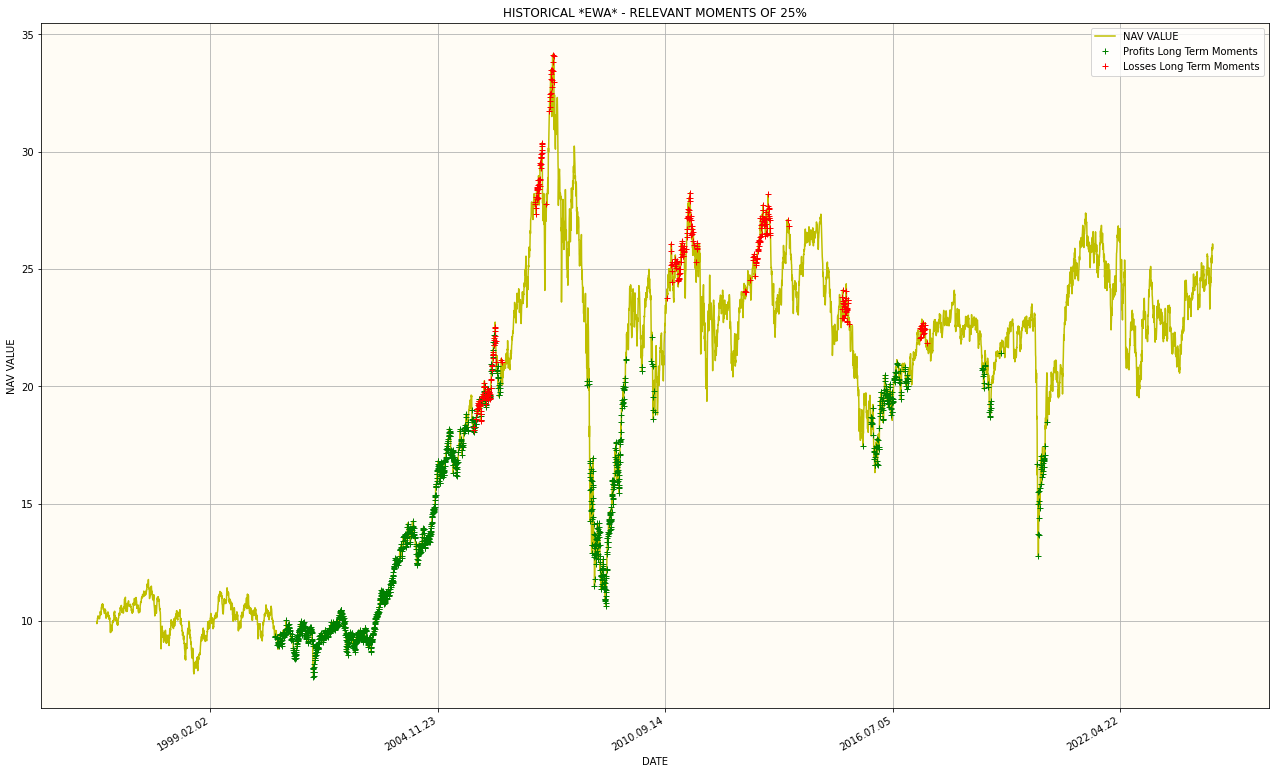

<Figure size 460.8x345.6 with 0 Axes>

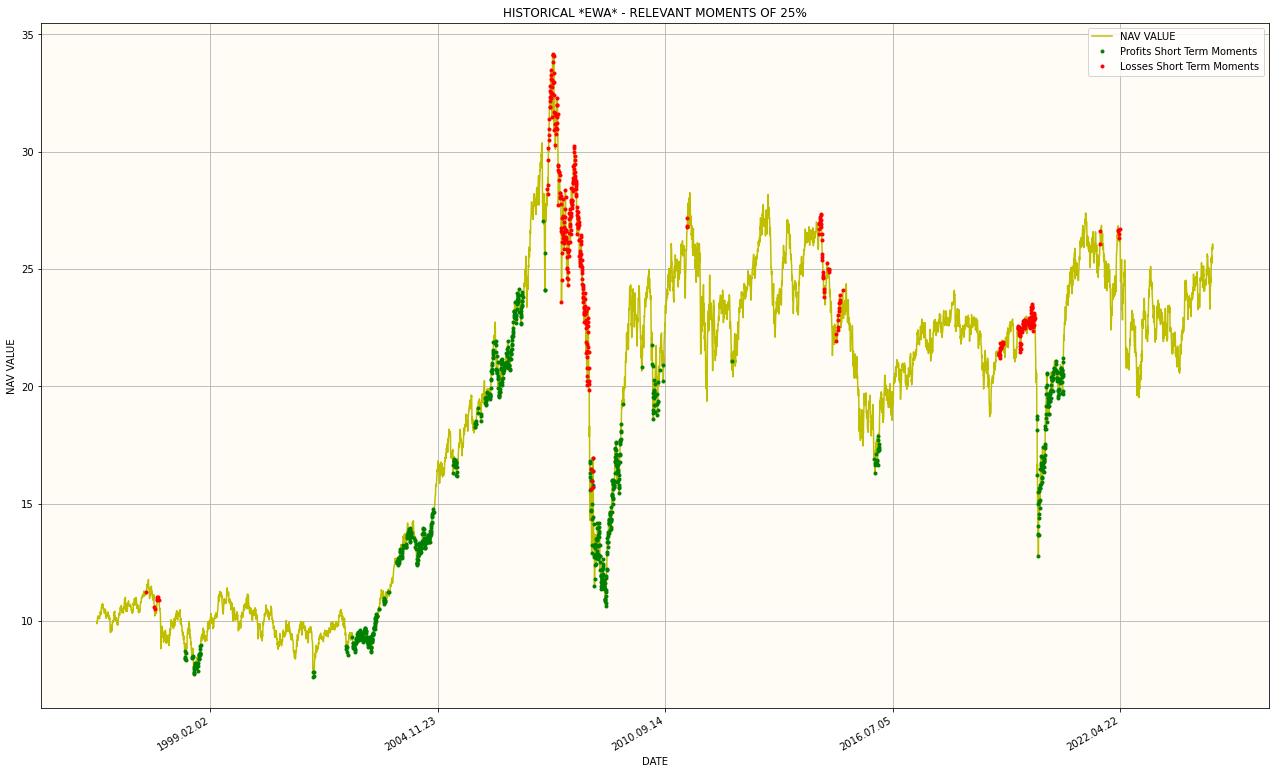

<Figure size 460.8x345.6 with 0 Axes>

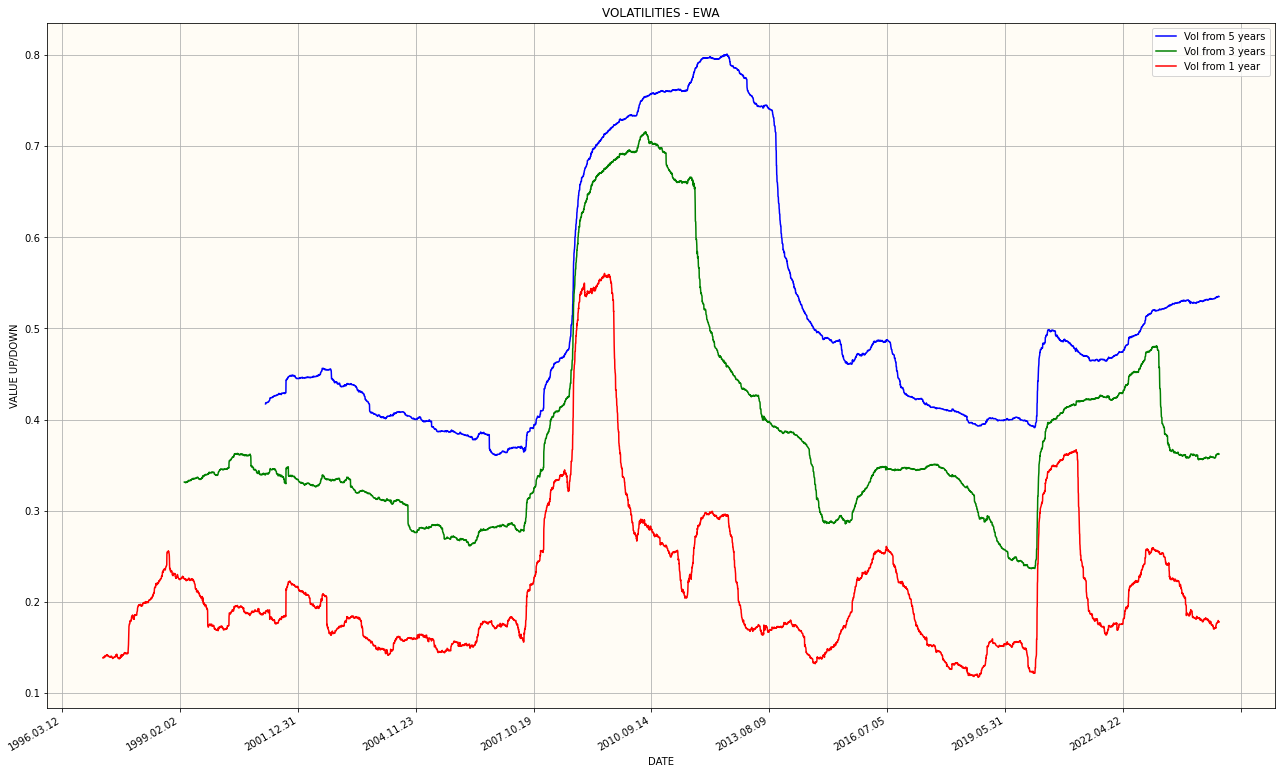

<Figure size 460.8x345.6 with 0 Axes>

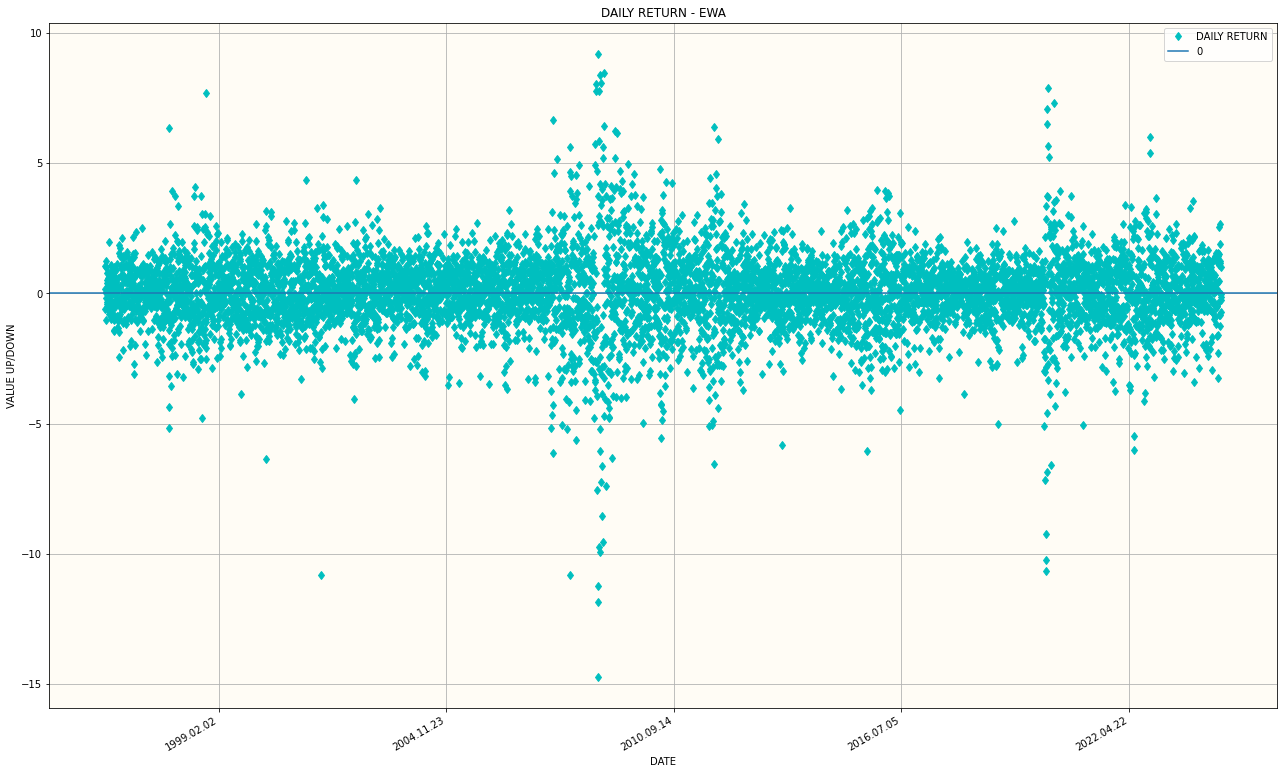

In [155]:
//filt_etf: exec distinct ticker from resume_etf where market = `$"Developed"
filt_etf: (`EWA);
{hist_lp_relev[x]} each filt_etf;
{hist_cp_relev[x]} each filt_etf;
{daily_vol[x]} each filt_etf;
{daily_ret[x]} each filt_etf;

In [ ]:
// RELEVANT MOMENT IN THE SHARE PRICES

// Losses

mom_los_q_date:{[ETF]  
    string each (select date from historical where ticker=ETF)`date
 }
mom_los_lp_q:{[ETF]
    a: select date, nav_value from historical where ticker=ETF;
    b: select distinct date, nav_value from table_losses where ticker=ETF, elem in (`p5y;`p3y);
    a: update nav_value: 0n from a; 
    a: a lj `date xkey b;
    (select nav_value from a )`nav_value
 }
mom_los_cp_q:{[ETF]
    a: select date, nav_value from historical where ticker=ETF;
    b: select distinct date, nav_value from table_losses where ticker=ETF, elem in (`p1y;`p6m;`p3m);;
    a: update nav_value: 0n from a; 
    a: a lj `date xkey b;
    (select nav_value from a )`nav_value
 }

// Profits
mom_prof_q_date:{[ETF]
    string each (select distinct date from table_profits where ticker=ETF)`date
 }
mom_prof_lp_q:{[ETF]
    a: select date, nav_value from historical where ticker=ETF;
    b: select distinct date, nav_value from table_profits where ticker=ETF, elem in (`p5y;`p3y);
    a: update nav_value: 0n from a; 
    a: a lj `date xkey b;
    (select nav_value from a )`nav_value 
 }
mom_prof_cp_q:{[ETF]
    a: select date, nav_value from historical where ticker=ETF;
    b: select distinct date, nav_value from table_profits where ticker=ETF, elem in (`p1y;`p6m;`p3m);
    a: update nav_value: 0n from a; 
    a: a lj `date xkey b;
    (select nav_value from a )`nav_value
 }


In [ ]:
vol_y5y:{[ETF]
    (select daily_5yvol from historical where ticker=ETF)`daily_5yvol
 }
vol_y3y:{[ETF]
    (select daily_3yvol from historical where ticker=ETF)`daily_3yvol
 }
vol_y1y:{[ETF]
    (select daily_1yvol from historical where ticker=ETF)`daily_1yvol
 }
d_ret:{[ETF]
    (select daily_retns*100 from historical where ticker=ETF)`daily_retns
 }
d_perf:{[ETF]
    (select daily_performance from historical where ticker=ETF)`daily_performance
 }

In [ ]:
meta historical

# Extras + info futuro


In [ ]:
count select ticker from resume_etf where market = `$"Developed"
select from historical where ticker = `EWA, m200sma <> 0N
count select ticker from resume_etf where market = `Emerging

//Filtrado  mezclando las dos tablas
select from historical where ticker in exec ticker from resume_etf where market = `$"Emerging"
//Lo mismo
show a: select ticker from resume_etf where market = `$"Developed"
select from historical where ticker in a[`ticker]

select distinct equity_class from resume_etf
select distinct region from resume_etf

//maximo aumento
select from historical where daily_retns=(max; daily_retns) fby ticker

In [ ]:
daily_return:{ [ETFa]

    plt[`:figure][(`figsize);(22;14)];
    plt[`:plot][daily_retns_q_date[ETFa];daily_retns_q[ETFa];"r+"];
    plt[`:axhline][0];
    ax: plt[`:gca][];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];  
    title: "DAILY RETURN - ",(string ETFa);
    plt[`:title][title];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["VALUE UP/DOWN"];
    plt[`:legend][("DAILY RETURN";"0 LINE")];
    plt[`:show][];
    plt[`:clf][];
 };
{daily_return[x]} each etfs;

In [ ]:
disp_vol:{ [ETFa]
    plt[`:figure][(`figsize);(22;14)];
    plt[`:plot][vol_x1y[ETFa];vol_y1y[ETFa];"r-"];
    plt[`:plot][vol_x[ETFa];vol_y[ETFa];"b+"];
    ax: plt[`:gca][];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];  
    title: "DAILY RETURN - ",(string ETFa);
    plt[`:title][title];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["VALUE UP/DOWN"];
    plt[`:legend][("DAILY";"0")];
    plt[`:show][];
    plt[`:clf][];
 }
{disp_vol[x]} each etfs;

In [ ]:
daily_vol:{ [ETFa]

    plt[`:figure][(`figsize);(22;14)];

    plt[`:plot][vol_x1y[ETFa];vol_y1y[ETFa];"r"];
    plt[`:plot][vol_x5y[ETFa];vol_y5y[ETFa];"b"];
    plt[`:plot][ax_x[ETFa];ax_y[ETFa];"g"];

    ax: plt[`:gca][];
    ax[`:xaxis][`:set_major_locator][mdates[`:AutoDateLocator][]];
    plt[`:xticks][;][;][(`rotation;45)];
    plt[`:gcf][][`:autofmt_xdate][];  
    title: "DAILY RETURN - ",(string ETFa);
    plt[`:title][title];
    plt[`:xlabel]["DATE"];
    plt[`:ylabel]["VALUE UP/DOWN"];
    plt[`:legend][("DAILY";"0")];
    plt[`:show][];
    plt[`:clf][];
 }
{daily_vol[x]} each etfs;